In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from cgpdm import CGPDM
from dataset_utils.mocap_labels import WALK_TRIALS_TRAIN, WALK_TRIALS_TEST, RUN_TRIALS_TRAIN, RUN_TRIALS_TEST
import dataset_utils.select_joints as select_joints

<frozen importlib._bootstrap>:488: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


pygame 2.6.1 (SDL 2.30.7, Python 3.12.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
gpdm_save_name = "cgpdm"

In [3]:
reduced_columns = WALK_TRIALS_TRAIN[0].get_columns_for_joints(select_joints.WALKING_SIMPLIFIED_JOINTS)
DOFs = len(reduced_columns)
print(f"Number of DOFs: {DOFs}")


Number of DOFs: 35


In [4]:
walk_train_dfs = [trial.as_dataframe() for trial in WALK_TRIALS_TRAIN]
walk_train_arrs = [df[reduced_columns].to_numpy().astype(np.float32)[::5, :] for df in walk_train_dfs]

run_train_dfs = [trial.as_dataframe() for trial in RUN_TRIALS_TRAIN]
run_train_arrs = [df[reduced_columns].to_numpy().astype(np.float32)[::5, :] for df in run_train_dfs]


In [5]:
d = 3 # latent space dimension
DOFs = len(reduced_columns)  # number of degrees of freedom

dyn_back_step = 1 # Number of time steps to look back in the dynamics GP

# Initial values for hyperparameters
y_lambdas_init = np.ones(DOFs)  # Signal standard deviation for observation GP
y_lengthscales_init = np.ones(d)  # Lengthscales for observation GP
y_sigma_n_init = 1e-2  # Noise standard deviation for observation GP

x_lambdas_init = np.ones(d)  # Signal standard deviation for latent dynamics GP
x_lengthscales_init = np.ones(dyn_back_step*d)  # Lengthscales for latent dynamics GP
x_sigma_n_init = 1e-2  # Noise standard deviation for latent dynamics GP
x_lin_coeff_init = np.ones(dyn_back_step*d + 1)  # Linear coefficients for latent dynamics GP


In [6]:
gpdm = CGPDM(
        D=DOFs,
        d=d,
        n_classes=2,
        dyn_target='full',
        dyn_back_step=dyn_back_step,
        y_lambdas_init=y_lambdas_init,
        y_lengthscales_init=y_lengthscales_init,
        y_sigma_n_init=y_sigma_n_init,
        x_lambdas_init=x_lambdas_init,
        x_lengthscales_init=x_lengthscales_init,
        x_sigma_n_init=x_sigma_n_init,
        x_lin_coeff_init=x_lin_coeff_init
    )

In [7]:
for train_arr in walk_train_arrs[0:6]:
    gpdm.add_data(train_arr, 0)
for train_arr in run_train_arrs[0:6]:
    gpdm.add_data(train_arr, 1)

#print('Num. of sequences = '+str(gpdm.num_sequences)+' [Data points = '+str(np.concatenate(gpdm.observations_list, 0).shape[0])+']')



### Model Training (Adam) ###

GPDM Opt. EPOCH: 0
Running loss: 1.0377e+07
Update time: 0.26021623611450195

GPDM Opt. EPOCH: 10
Running loss: 3.3800e+06
Update time: 3.1965112686157227

GPDM Opt. EPOCH: 20
Running loss: 1.4060e+06
Update time: 2.3497684001922607

GPDM Opt. EPOCH: 30
Running loss: 6.4176e+05
Update time: 3.763434648513794

GPDM Opt. EPOCH: 40
Running loss: 3.4299e+05
Update time: 3.2427895069122314

GPDM Opt. EPOCH: 50
Running loss: 2.0206e+05
Update time: 2.9896240234375

GPDM Opt. EPOCH: 60
Running loss: 1.2371e+05
Update time: 2.79207181930542

GPDM Opt. EPOCH: 70
Running loss: 8.8589e+04
Update time: 2.230451822280884

GPDM Opt. EPOCH: 80
Running loss: 7.2380e+04
Update time: 3.7808563709259033

GPDM Opt. EPOCH: 90
Running loss: 6.2940e+04
Update time: 2.7316668033599854

GPDM Opt. EPOCH: 100
Running loss: 5.5942e+04
Update time: 2.6111178398132324

GPDM Opt. EPOCH: 110
Running loss: 5.0038e+04
Update time: 1.9885952472686768

GPDM Opt. EPOCH: 120
Running loss: 4.

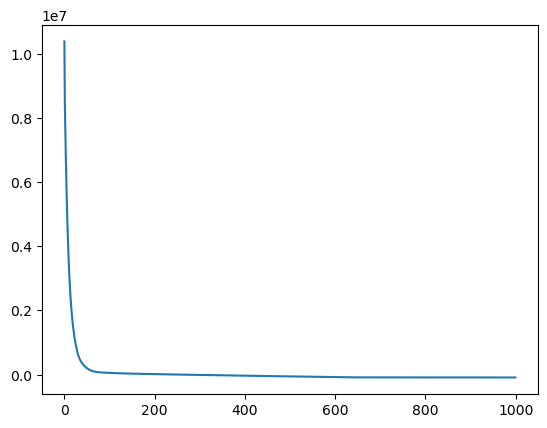

In [8]:
gpdm.init_X()  
losses = gpdm.train_adam(num_opt_steps=1000, num_print_steps=10, lr=0.05)

gpdm.save(f'{gpdm_save_name}_config.pth', f'{gpdm_save_name}_state.pth')  

plt.plot(losses)

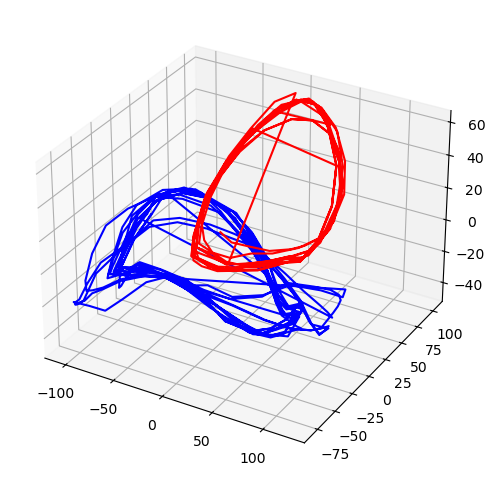

In [9]:
# Plot the latent space
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
X0 = gpdm.get_X_for_class(0).detach().numpy()
X1 = gpdm.get_X_for_class(1).detach().numpy()

# plot X0 in blue and X1 in red
ax.plot(X0[:, 0], X0[:, 1], X0[:, 2], 'b')
ax.plot(X1[:, 0], X1[:, 1], X1[:, 2], 'r')

plt.show()